> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Before submitting your project, it will be a good idea to go back through your report and remove these sections to make the presentation of your work as tidy as possible. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: European Soccer Database

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

Note about dataset, description, questions asked go here

### From project description

- A note specifying which dataset you analyzed
- A statement of the question(s) you posed

### Example Questions

- What teams improved the most over the time period?
- Which players had the most penalties?
- What team attributes lead to the most victories?

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#missingno for visualizations of missing values
import missingno as msno

#'magic word' so that visualizations are plotted inline with the notebook
% matplotlib inline

# connection to sqlite3 database
db = sqlite3.connect('database.sqlite')

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you document your steps carefully and justify your cleaning decisions.

### From project description

- A description of what you did to investigate those questions
- Documentation of any data wrangling you did

### General Properties

I'll need to look at the tables for: match, league, country, 

In [2]:
# First, look at tables in the database
tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""",db)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


In [3]:
countries = pd.read_sql("""SELECT *
                           FROM Country;""", db)


leagues = pd.read_sql("""SELECT id, name
                     FROM League;""", db)
display(countries)
display(leagues)

,id,name
0,1,Belgium
1,1729,England
2,4769,France
3,7809,Germany
4,10257,Italy
5,13274,Netherlands
6,15722,Poland
7,17642,Portugal
8,19694,Scotland
9,21518,Spain


,id,name
0,1,Belgium Jupiler League
1,1729,England Premier League
2,4769,France Ligue 1
3,7809,Germany 1. Bundesliga
4,10257,Italy Serie A
5,13274,Netherlands Eredivisie
6,15722,Poland Ekstraklasa
7,17642,Portugal Liga ZON Sagres
8,19694,Scotland Premier League
9,21518,Spain LIGA BBVA


In [4]:
matches = pd.read_sql("""SELECT *
                       FROM match;""", db)
matches.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.00,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.80,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75
3,4,1,1,2008/2009,1,2008-08-17 00:00:00,492476,9991,9998,5,...,7.50,1.45,3.75,6.50,1.50,3.75,5.50,1.44,3.75,6.50
4,5,1,1,2008/2009,1,2008-08-16 00:00:00,492477,7947,9985,1,...,1.73,4.50,3.40,1.65,4.50,3.50,1.65,4.75,3.30,1.67


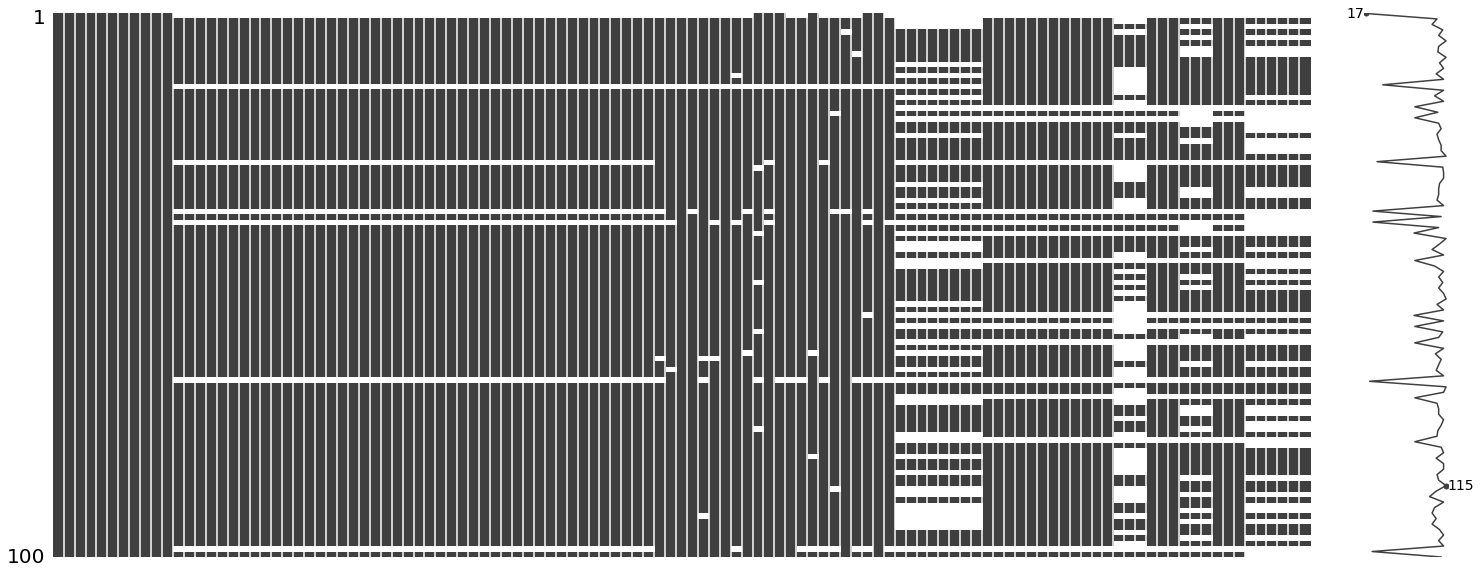

In [5]:
# visual missing values in the matches table
msno.matrix(matches.sample(100))

In [6]:
print("Columns: ", len(list(matches)))

Columns:  115


In [2]:
matches_redux = pd.read_sql("""SELECT Country.name AS country_name,
                            season,
                            stage,
                            home.team_long_name AS  home_team,
                            away.team_long_name AS away_team,
                            home_team_goal AS home_goals,
                            away_team_goal AS away_goals,
                            goal,
                            shoton,
                            shotoff,
                            foulcommit,
                            card,
                            cross,
                            corner,
                            possession
                        FROM Match
                        JOIN Country on Country.id = Match.country_id
                        JOIN League on League.id = Match.league_id
                        LEFT JOIN Team AS home on home.team_api_id = Match.home_team_api_id
                        LEFT JOIN Team AS away on away.team_api_id = Match.away_team_api_id
                        ORDER by season;""", db)
matches_redux.head()

,country_name,season,stage,home_team,away_team,home_goals,away_goals,goal,shoton,shotoff,foulcommit,card,cross,corner,possession
0,Belgium,2008/2009,1,KRC Genk,Beerschot AC,1,1,None,None,None,None,None,None,None,None
1,Belgium,2008/2009,1,SV Zulte-Waregem,Sporting Lokeren,0,0,None,None,None,None,None,None,None,None
2,Belgium,2008/2009,1,KSV Cercle Brugge,RSC Anderlecht,0,3,None,None,None,None,None,None,None,None
3,Belgium,2008/2009,1,KAA Gent,RAEC Mons,5,0,None,None,None,None,None,None,None,None
4,Belgium,2008/2009,1,FCV Dender EH,Standard de Liège,1,3,None,None,None,None,None,None,None,None


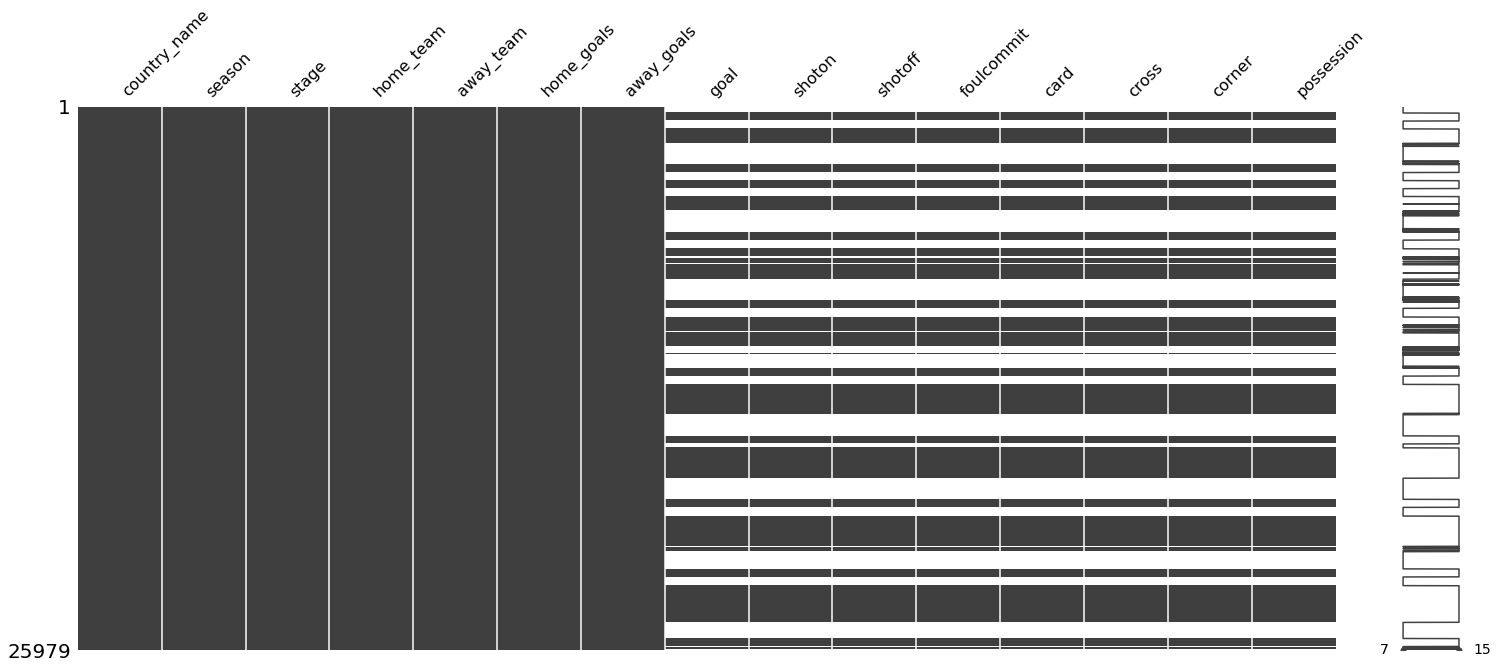

In [8]:
msno.matrix(matches_redux)

### Data Cleaning (Replace this with more specific notes!)

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.

# https://www.kaggle.com/dimarudov/data-analysis-using-sql
# Top 5 teams by UEFA coefficient: https://www.uefa.com/memberassociations/uefarankings/country/ 
goals_by_season = pd.read_sql("""SELECT Country.name AS country_name,  
                                        season,
                                        count(distinct stage) AS games,
                                        count(distinct home.team_long_name) AS teams,
                                        sum(home_team_goal) AS home_goals,
                                        sum(away_team_goal) AS away_goals,
                                        sum(home_team_goal+away_team_goal) AS total_goals,
                                        avg(home_team_goal) AS avg_home_goals, 
                                        avg(away_team_goal) AS avg_away_goals, 
                                        avg(home_team_goal-away_team_goal) AS avg_goal_dif, 
                                        avg(home_team_goal+away_team_goal) AS avg_goals
                                FROM Match
                                JOIN Country on Country.id = Match.country_id
                                JOIN League on League.id = Match.league_id
                                LEFT JOIN Team AS home on home.team_api_id = Match.home_team_api_id
                                LEFT JOIN Team AS away on away.team_api_id = Match.away_team_api_id
                                WHERE country_name in ('Spain', 'England', 'Italy', 'Germany', 'France')
                                GROUP BY Country.name, League.name, season
                                ORDER BY Country.name, League.name, season DESC;""", db)
goals_by_season

,country_name,season,games,teams,home_goals,away_goals,total_goals,avg_home_goals,avg_away_goals,avg_goal_dif,avg_goals
0,England,2015/2016,38,20,567,459,1026,1.492105,1.207895,0.284211,2.700000
1,England,2014/2015,38,20,560,415,975,1.473684,1.092105,0.381579,2.565789
2,England,2013/2014,38,20,598,454,1052,1.573684,1.194737,0.378947,2.768421
3,England,2012/2013,38,20,592,471,1063,1.557895,1.239474,0.318421,2.797368
4,England,2011/2012,38,20,604,462,1066,1.589474,1.215789,0.373684,2.805263
5,England,2010/2011,38,20,617,446,1063,1.623684,1.173684,0.450000,2.797368
6,England,2009/2010,38,20,645,408,1053,1.697368,1.073684,0.623684,2.771053
7,England,2008/2009,38,20,532,410,942,1.400000,1.078947,0.321053,2.478947
8,France,2015/2016,38,20,546,414,960,1.436842,1.089474,0.347368,2.526316
9,France,2014/2015,38,20,536,411,947,1.410526,1.081579,0.328947,2.492105


The SQL query below does a pretty good job of pulling clean data from the database, but let's check some things anyway.

First, I'll check the shape to make sure we are seeing all rows and all columns:

In [10]:
# shape (rows, columns)
print("Shape: ", goals_by_season.shape)

Shape:  (40, 11)


Indeed, we are seeing all rows and all columns.

Now, we should also check datatypes and double-check for null values:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40 entries, 0 to 39
Data columns (total 11 columns):
country_name      40 non-null object
season            40 non-null object
games             40 non-null int64
teams             40 non-null int64
home_goals        40 non-null int64
away_goals        40 non-null int64
total_goals       40 non-null int64
avg_home_goals    40 non-null float64
avg_away_goals    40 non-null float64
avg_goal_dif      40 non-null float64
avg_goals         40 non-null float64
dtypes: float64(4), int64(5), object(2)
memory usage: 3.5+ KB
None


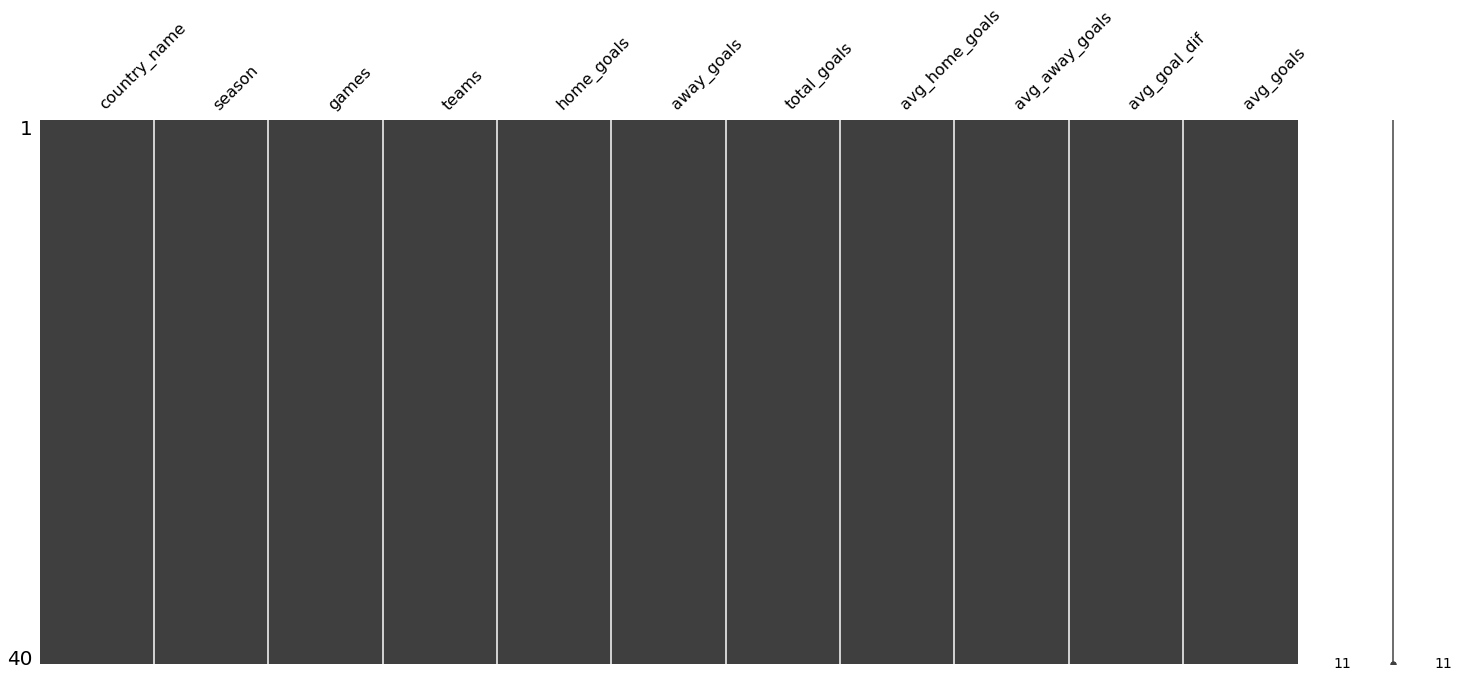

In [11]:
# info
print(goals_by_season.info())
msno.matrix(goals_by_season)

Everything looks good.

In [15]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.


<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. Compute statistics and create visualizations with the goal of addressing the research questions that you posed in the Introduction section. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables.

Summary statistics and plots communicating your final results (From project description)

### Research Question 1: Total Goals

,England,France,Germany,Italy,Spain
2008/2009,1026,960,866,979,1043
2009/2010,975,947,843,1018,1009
2010/2011,1052,933,967,1035,1045
2011/2012,1063,967,898,1003,1091
2012/2013,1066,956,875,925,1050
2013/2014,1063,890,894,955,1042
2014/2015,1053,916,866,992,1031
2015/2016,942,858,894,988,1101


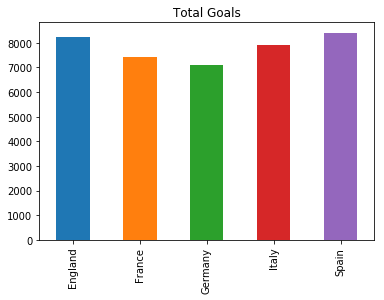

In [28]:
# set up empty dataframe
df_total = pd.DataFrame(index=np.sort(goals_by_season['season'].unique()), columns=goals_by_season['country_name'].unique())
# add values by country
df_total.loc[:,'England'] = list(goals_by_season.loc[goals_by_season['country_name']=='England','total_goals'])
df_total.loc[:,'France'] = list(goals_by_season.loc[goals_by_season['country_name']=='France','total_goals'])
df_total.loc[:,'Germany'] = list(goals_by_season.loc[goals_by_season['country_name']=='Germany','total_goals'])
df_total.loc[:,'Italy'] = list(goals_by_season.loc[goals_by_season['country_name']=='Italy','total_goals'])
df_total.loc[:,'Spain'] = list(goals_by_season.loc[goals_by_season['country_name']=='Spain','total_goals'])


# display dataframe
display(df_total)
# plot totals
display(plot = df_total.sum().plot(kind="bar",title="Total Goals"))

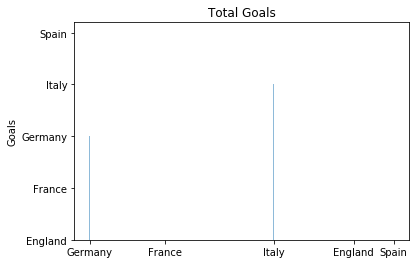

### Research Question 2: Average Goals

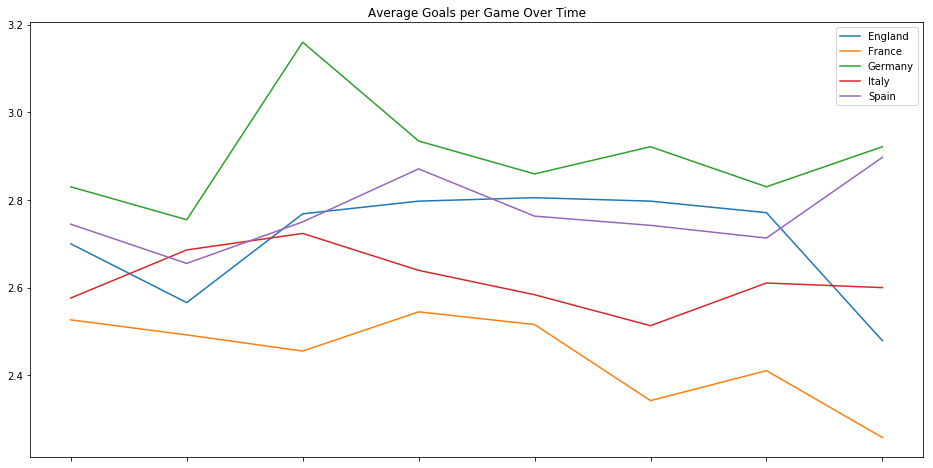

In [5]:
# https://www.kaggle.com/dimarudov/data-analysis-using-sql

df = pd.DataFrame(index=np.sort(goals_by_season['season'].unique()), columns=goals_by_season['country_name'].unique())

df.loc[:,'Spain'] = list(goals_by_season.loc[goals_by_season['country_name']=='Spain','avg_goals'])
df.loc[:,'England'] = list(goals_by_season.loc[goals_by_season['country_name']=='England','avg_goals'])
df.loc[:,'Italy'] = list(goals_by_season.loc[goals_by_season['country_name']=='Italy','avg_goals'])
df.loc[:,'Germany'] = list(goals_by_season.loc[goals_by_season['country_name']=='Germany','avg_goals'])
df.loc[:,'France'] = list(goals_by_season.loc[goals_by_season['country_name']=='France','avg_goals'])

df.plot(figsize=(16,8), title='Average Goals per Game Over Time')

### Research Question 3:  Home vs. Away Goals

In [127]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


,spain_home,spain_away,england_home,england_away,italy_home,italy_away,germany_home,germany_away,france_home,france_away
2008/2009,615,428,567,459,559,420,479,387,546,414
2009/2010,584,425,560,415,568,450,486,357,536,411
2010/2011,620,425,598,454,584,451,535,432,538,395
2011/2012,641,450,592,471,568,435,487,411,558,409
2012/2013,638,412,604,462,541,384,508,367,560,396
2013/2014,622,420,617,446,544,411,504,390,510,380
2014/2015,608,423,645,408,586,406,463,403,528,388
2015/2016,631,470,532,410,578,410,520,374,489,369


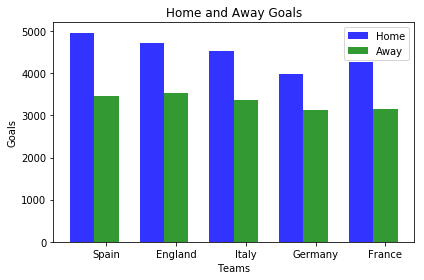

In [14]:
home_and_away = pd.DataFrame(index=np.sort(goals_by_season['season'].unique()),
                             columns=['spain_home','spain_away',
                                      'england_home','england_away',
                                      'italy_home','italy_away',
                                      'germany_home','germany_away',
                                      'france_home','france_away'])

home_and_away.loc[:,'spain_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='Spain','home_goals'])
home_and_away.loc[:,'spain_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='Spain','away_goals'])
home_and_away.loc[:,'england_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='England','home_goals'])
home_and_away.loc[:,'england_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='England','away_goals'])
home_and_away.loc[:,'italy_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='Italy','home_goals'])
home_and_away.loc[:,'italy_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='Italy','away_goals'])
home_and_away.loc[:,'germany_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='Germany','home_goals'])
home_and_away.loc[:,'germany_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='Germany','away_goals'])
home_and_away.loc[:,'france_home'] = list(goals_by_season.loc[goals_by_season['country_name']=='France','home_goals'])
home_and_away.loc[:,'france_away'] = list(goals_by_season.loc[goals_by_season['country_name']=='France','away_goals'])


display(home_and_away)

# data to plot
n_groups = 5
home_goals = (home_and_away['spain_home'].sum(),home_and_away['england_home'].sum(),home_and_away['italy_home'].sum(),
             home_and_away['germany_home'].sum(),home_and_away['france_home'].sum())
away_goals = (home_and_away['spain_away'].sum(),home_and_away['england_away'].sum(),home_and_away['italy_away'].sum(),
             home_and_away['germany_away'].sum(),home_and_away['france_away'].sum())
 
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
 
rects1 = plt.bar(index, home_goals, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Home')
 
rects2 = plt.bar(index + bar_width, away_goals, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Away')
 
plt.xlabel('Teams')
plt.ylabel('Goals')
plt.title('Home and Away Goals')
plt.xticks(index + bar_width, ('Spain', 'England', 'Italy', 'Germany','France'))
plt.legend()
 
plt.tight_layout()
plt.show()

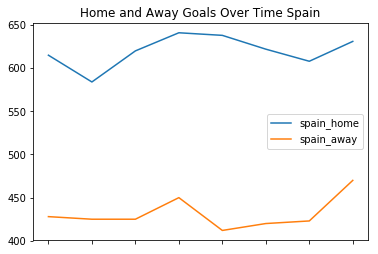

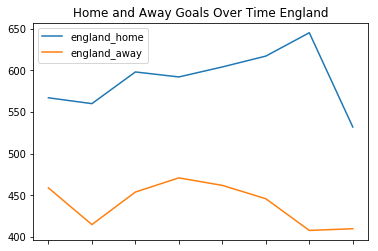

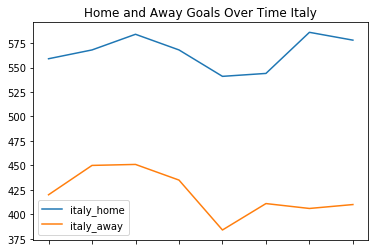

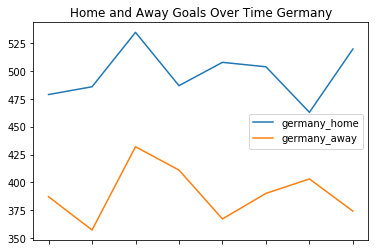

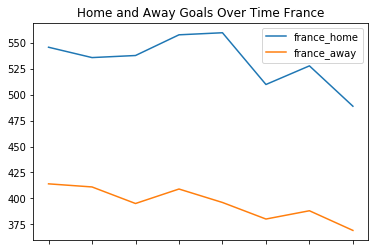

In [7]:
esp = home_and_away[['spain_home','spain_away']]
display(esp.plot(title="Home and Away Goals Over Time Spain"))

gba = home_and_away[['england_home','england_away']]
display(gba.plot(title="Home and Away Goals Over Time England"))

itl = home_and_away[['italy_home','italy_away']]
display(itl.plot(title="Home and Away Goals Over Time Italy"))

ale = home_and_away[['germany_home','germany_away']]
display(ale.plot(title="Home and Away Goals Over Time Germany"))

fra = home_and_away[['france_home','france_away']]
display(fra.plot(title="Home and Away Goals Over Time France"))

<a id='conclusions'></a>
## Conclusions

> **Tip**: Finally, summarize your findings and the results that have been performed. Make sure that you are clear with regards to the limitations of your exploration. If you haven't done any statistical tests, do not imply any statistical conclusions. And make sure you avoid implying causation from correlation!

> **Tip**: Once you are satisfied with your work, you should save a copy of the report in HTML or PDF form via the **File** > **Download as** submenu. Before exporting your report, check over it to make sure that the flow of the report is complete. You should probably remove all of the "Tip" quotes like this one so that the presentation is as tidy as possible. Congratulations!